<center><h2>Import Libraries</h2><center>

In [ ]:
!pip install -q pyicu
!pip install -q pycld2
!pip install -q polyglot
!pip install -q textstat
!pip install -q googletrans

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as plty
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from colorama import Fore, Back, Style, init

import spacy
from wordcloud import WordCloud

from polyglot.detect import Detector
import pycountry

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from googletrans import Translator
import textstat

import re

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

from kaggle_datasets import KaggleDatasets
import transformers
import tensorflow as tf
from tokenizers import BertWordPieceTokenizer

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import LSTM, GRU, Conv1D, SpatialDropout1D

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

# to set a style to all graphs
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")
sns.set_context("paper")

<center><h2>Load Data</h2></center>

In [ ]:
INPUT_DIR = '../input/jigsaw-multilingual-toxic-comment-classification/'

TRAIN_PATH = INPUT_DIR + 'jigsaw-toxic-comment-train.csv'
TEST_PATH = INPUT_DIR + 'test.csv'
VAL_PATH = INPUT_DIR + 'validation.csv'

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
val_df = pd.read_csv(VAL_PATH)

display('TRAINING DATA')
display(train_df.head(5))

display('TEST DATA')
display(test_df.head(5))

display('VALIDATION DATA')
display(val_df.head(5))

<center><h2>Looking at the comments from Train data</h2></center>

In [ ]:
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

'''
def preprocess_text(text):
    doc = nlp(text, disable=['ner','parser'])
    lemmas = [token.lemma_ for token in doc]
    a_lemmas = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stop_words]
    return ' '.join(a_lemmas)

train_comments = train_df['comment_text'].progress_apply(preprocess_text)
'''
#Create an o/p file for reading directly if session expires or new session
#train_comments.to_csv('comments.csv')

In [ ]:
train_comments = pd.read_csv('../input/comments/comments.csv')
train_comments.drop(train_comments.columns[0], axis=1, inplace=True)

In [ ]:
string = ' '.join(train_comments['comment_text'].dropna())

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(string.lower())
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments')

<b>
    As of now we don't seen any toxic words in the above Word Cloud.<br> It seems those words have not been used frequently in the comments.</b>

<h2>Let's Detect Languages and Countries</h2>

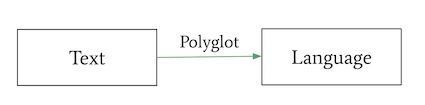
<br>
We will be using pycountry to get Full Language names and also the Country names

In [ ]:
# This will return language code, eg: 'en' for English
def detect_language(text):
    return Detector("".join(x for x in text if x.isprintable()), quiet=True).languages[0].name


#This function will Fetch Full Language Name by passing Language code
def get_full_name(lang_code):
    try:
        Name = pycountry.languages.get(alpha_2=lang_code).name
    except:
        Name = None
    return Name


train_df['lang_code'] = train_df['comment_text'].progress_apply(detect_language)
train_df['lang'] = train_df['lang_code'].progress_apply(get_full_name)

In [ ]:
def get_country(language):
    if language == "German":
        return "Germany"
    if language == "Scots":
        return "Scotland"
    if language == "Danish":
        return "Denmark"
    if language == "Arabic":
        return "Saudi Arabia"
    if language == "Spanish":
        return "Spain"
    if language == "Persian":
        return "Iran"
    if language == "Greek":
        return "Greece"
    if language == "Portuguese":
        return "Portugal"
    if language == "English":
        return "United Kingdom"
    if language == "Hindi":
        return "India"
    if language == "Albanian":
        return "Albania"
    if language == "Bosnian":
        return "Bosnia and Herzegovina"
    if language == "Croatian":
        return "Croatia"
    if language == "Dutch":
        return "Netherlands"
    if language == "Russian":
        return "Russia"
    if language == "Vietnamese":
        return "Vietnam"
    if language == "Somali":
        return "Somalia"
    if language == "Turkish":
        return "Turkey"
    if language == "Serbian":
        return "Serbia"
    if language == "Indonesian":
        return "Indonesia"
    if language == "Manx":
        return "Ireland"
    if language == "Scots":
        return "Scotland"
    if language == "Latin":
        return "Holy See (Vatican City State)"
    if language == "Afrikaans":
        return "South Africa"
    return "None"

In [ ]:
train_df['lang'].value_counts()[:10]

In [ ]:
total_comments = train_df['lang_code'].count()
english_comments = train_df['lang_code'].value_counts().loc['en']
languages = ['English','Non-English']
count = [english_comments, total_comments-english_comments]

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "bar"}, {"type": "pie"}]])
fig.add_trace(go.Bar(x=languages,y=count,text=count, marker_color=['#64D9D1','#D9636B']),
             row=1, col=1)
fig.add_trace(go.Pie(labels=languages, values=count, domain=dict(x=[0.5, 1.0]), marker_colors=['#64D9D1','#D9636B']), 
              row=1, col=2)

fig.update_layout(height=600, width=800, title_text="English vs Non-English", template='plotly_white')

fig.show()

It is clear that the comment section is mostly in English with more than 98% usage.

In [ ]:
df = train_df['lang'].value_counts()[1:6].reset_index()
df.columns = ['Language','Count']

fig = px.bar(df,
             y="Language", x="Count", title="Non-English comments", template="plotly_white", 
             color="Language", text="Count", orientation="h")
fig.update_traces(marker=dict(line=dict(width=0.75,
                                        color='black')),  textposition="outside")
fig.update_layout(showlegend=False)
fig

In [ ]:
df = train_df['lang'].value_counts().reset_index()
df.columns = ['Language','Count']
df["country"] = df["Language"].progress_apply(get_country)
 

fig = px.choropleth(df.query("Language != 'English' and Language != 'un' and country != 'None'").query("Count >= 5"), locations="country", hover_name="country",
                     projection="natural earth", locationmode="country names", title="Countries of non-English languages", color="Count",
                     template="plotly", color_continuous_scale="agsunset")
# fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
# fig.data[0].marker.line.width = 0.2
fig.show()

In [ ]:
fig = px.choropleth(df.query("Language != 'English' and Language != 'un' and country != 'None'"), locations="country", hover_name="country",
                     projection="natural earth", locationmode="country names", title="Non-English European countries", color="Count",
                     template="plotly", color_continuous_scale="aggrnyl", scope="europe")
# fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
# fig.data[0].marker.line.width = 0.2
fig.show()

In [ ]:
fig = px.choropleth(df.query("Language != 'English' and Language != 'un' and country != 'None'"), locations="country", hover_name="country",
                     projection="natural earth", locationmode="country names", title="Asian countries", color="Count",
                     template="plotly", color_continuous_scale="spectral", scope="asia")
# fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
# fig.data[0].marker.line.width = 0.2
fig.show()

In [ ]:
fig = px.choropleth(df.query("Language != 'English' and Language != 'un' and country != 'None'").query("Count >= 5"), locations="country", hover_name="country",
                     projection="natural earth", locationmode="country names", title="African countries", color="Count",
                     template="plotly", color_continuous_scale="agsunset", scope="africa")
# fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
# fig.data[0].marker.line.width = 0.2
fig.show()

### Distribution of Comment Words

In [ ]:
# Counting no of words in each comment
train_df['word_count'] = train_df['comment_text'].progress_apply(lambda x : len([word for word in x.split() if type(word) is str]))

#### Top 3 most verbose comments

In [ ]:
train_df.sort_values(by='word_count', ascending=False)[['comment_text','word_count']].head(3)

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle('Distribuition of Word count', fontsize=30)

ax1 = fig.add_subplot(121)
_ = sns.distplot(train_df['word_count'], bins=200,color='#e56b6f', ax=ax1)
_ = ax1.set_ylabel('Distribution', fontsize=20)
_ = ax1.set_xlabel('Word count', fontsize=20)


ax2 = fig.add_subplot(122)
_ = plt.scatter(range(train_df.shape[0]), np.sort(train_df['word_count'].values), color='#2a9d8f')
_ = ax2.set_ylabel('Word count', fontsize=20)
_ = ax2.set_xlabel('Comments', fontsize=20)

Majority of the comments are having average number of words around 100.
Also from the scatter plot on the right we can see that more than 2 lakh comments have word count less than 100

### Average Word count per Language

In [ ]:
top_15 = train_df.groupby('lang')['word_count'].mean().rename('Mean').reset_index().\
                                    sort_values(by='Mean', ascending=False)[:15]
bottom_15 = train_df.groupby('lang')['word_count'].mean().rename('Mean').reset_index().\
                                    sort_values(by='Mean')[:15]

In [ ]:
fig = make_subplots(rows=2, cols=1,subplot_titles=['Top 15', 'Bottom 15'])

fig.add_trace(go.Bar(x=top_15['lang'], y=top_15['Mean']), row=1, col=1)

fig.add_trace(go.Bar(x=bottom_15['lang'], y=bottom_15['Mean']), row=2, col=1)

fig.update_layout(height=900, width=800,yaxis_title="Average comment words", title_text="Average comment words vs. language", template="plotly_white")
fig.show()

## Translate comments

In [ ]:
translator = Translator()

def translate_text(comment_lang):
    comment, lang = comment_lang[0], comment_lang[1]
    try:
        if (lang == 'English' or lang == None):
            return comment
        else:
            return translator.translate(comment).text
    except:
        return None

train_df['translated_comment'] = train_df[['comment_text','lang']].progress_apply(lambda x: translate_text(x), axis=1)

## Sentiment Analysis
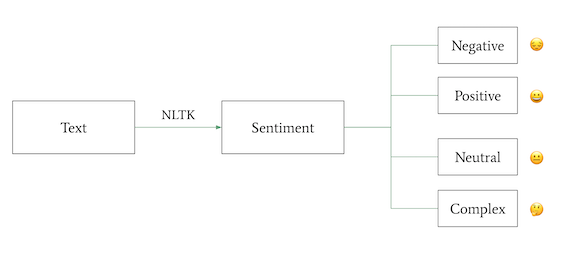

In [ ]:
def polarity(text):
    if type(text) == str:
        return SIA.polarity_scores(text)
    else:
        return 1000
    
SIA = SentimentIntensityAnalyzer()
train_df["polarity"] = train_df["translated_comment"].progress_apply(polarity)

### Negative Sentiment
Negative sentiment refers to negative or pessimistic emotions. It is a score between 0 and 1; the greater the score, the more negative the abstract is.

In [ ]:
neg_pol = [pols['neg'] for pols in train_df["polarity"] if type(pols) is dict]
neg_pol = list(filter((0.0).__ne__, neg_pol))

fig = go.Figure(go.Histogram(x=neg_pol, marker=dict(
            color='seagreen')
    ))

fig.update_layout(xaxis_title="Negativity sentiment", title_text="Negativity sentiment", template="simple_white")
fig.show()

From the above plot, we can see that negative sentiment has a strong rightward (positive) skew, indicating that negativity is usually on the lower side. This suggests that most comments are not toxic or negative. In fact, the most common negativity value is around 0.04. Virtually no comments have a negativity greater than 0.8.

### Negativity of Toxic vs Non-Toxic Comments

In [ ]:
toxic = [x['neg'] for x in train_df.sample(frac=0.1).query("toxic == 1")['polarity'] if type(x) == dict]
non_toxic = [x['neg'] for x in train_df.sample(frac=0.1).query("toxic == 0")['polarity'] if type(x) == dict]

fig = ff.create_distplot(hist_data=[toxic, non_toxic],
                         group_labels=["Toxic", "Non-toxic"],
                         colors=["darkorange", "dodgerblue"], show_hist=False)

fig.update_layout(title_text="Negativity of Toxic vs Non-toxic", xaxis_title="Negativity", template="simple_white")
fig.show()

We can clearly see that toxic comments have a significantly greater negative sentiment than toxic comments (on average). The probability density of negativity peaks at around 0 for non-toxic comments, while the negativity for toxic comments are minimum at this point. This suggests that a comment is very likely to be non-toxic if it has a negativity of 0.

### Positive Sentiment
Positive sentiment refers to positive or optimistic emotions. It is a score between 0 and 1; the greater the score, the more positive the abstract is.

In [ ]:
pos_pol = [pols['pos'] for pols in train_df["polarity"] if type(pols) is dict]
pos_pol = list(filter((0.0).__ne__, pos_pol))

fig = go.Figure(go.Histogram(x=pos_pol, marker=dict(
            color='seagreen')
    ))

fig.update_layout(xaxis_title="Positive sentiment", title_text="Positive sentiment", template="simple_white")
fig.show()

### Neutral Sentiment
Neutrality sentiment refers to the level of bias or opinion in the text. It is a score between 0 and 1; the greater the score, the more neutral/unbiased the abstract is.

In [ ]:
neu_pol = [pols['neu'] for pols in train_df["polarity"] if type(pols) is dict]
neu_pol = list(filter((1.0).__ne__, neu_pol))

fig = go.Figure(go.Histogram(x=neu_pol, marker=dict(
            color='seagreen')
    ))

fig.update_layout(xaxis_title="Neutral sentiment", title_text="Neutral sentiment", template="simple_white")
fig.show()

From the above plot, we can see that the neutrality sentiment distribution has a strong leftward (negative) skew, which is in constrast to the negativity and positivity sentiment distributions. This indicates that the comments tend to be very neutral and unbiased in general. This also suggests that most comments are not highly opinionated and polarizing, meaning that most comments are non-toxic.

### Compound sentiment
Compoundness sentiment refers to the total level of sentiment in the sentence. It is a score between -1 and 1; the greater the score, the more emotional the abstract is.

In [ ]:
neu_pol = [pols['compound'] for pols in train_df["polarity"] if type(pols) is dict]
neu_pol = list(filter((0.0).__ne__, neu_pol))

fig = go.Figure(go.Histogram(x=neu_pol, marker=dict(
            color='seagreen')
    ))

fig.update_layout(xaxis_title="Compound sentiment", title_text="Compund sentiment", template="simple_white")
fig.show()

In [ ]:
toxic = [x['compound'] for x in train_df.sample(frac=0.1).query("toxic == 1")['polarity'] if type(x) == dict]
non_toxic = [x['compound'] for x in train_df.sample(frac=0.1).query("toxic == 0")['polarity'] if type(x) == dict]

fig = ff.create_distplot(hist_data=[toxic, non_toxic],
                         group_labels=["Toxic", "Non-toxic"],
                         colors=["darkorange", "dodgerblue"], show_hist=False)

fig.update_layout(title_text="Compoundedness of Toxic vs Non-toxic", xaxis_title="Compound", template="simple_white")
fig.show()

We can see that compound sentiment tends to be higher for non-toxic comments as compared to toxic comments. The non-toxic distribution has a leftward (negative) skew, while the toxic distribution has a positive (rightward) skew. This indicates that non-toxic comments tend to have a higher compound sentiment than toxic comments on average.

### Readability 
Readability is an indication of how "easy" it is to read some text. There are several metrics that can be used to measure the readability of a piece of text, including Flesch reading ease, automated readability, and Dale-Chall readability.

In [ ]:
train_df["flesch_reading_ease"] = train_df["comment_text"].progress_apply(textstat.flesch_reading_ease)
train_df["automated_readability"] = train_df["comment_text"].progress_apply(textstat.automated_readability_index)
train_df["dale_chall_readability"] = train_df["comment_text"].progress_apply(textstat.dale_chall_readability_score)

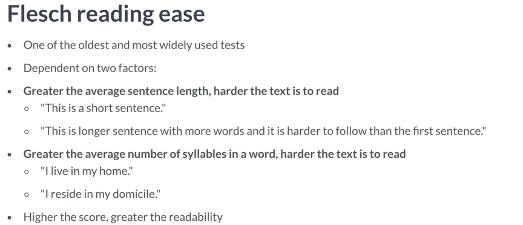

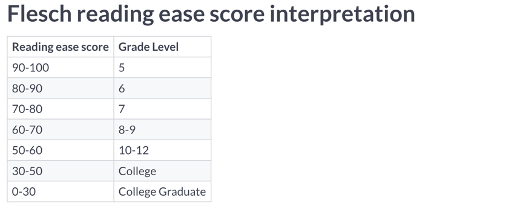

In [ ]:
fig = go.Figure(go.Histogram(x=train_df.query("flesch_reading_ease > 0")["flesch_reading_ease"], marker=dict(
            color='darkorange')
    ))

fig.update_layout(xaxis_title="Flesch reading ease", title_text="Flesch reading ease", template="simple_white")
fig.show()

## Target Variables

In [ ]:
# Count of Different Negative categories of comments
train_df[train_df.columns[2:8]].sum(axis=0).rename('Count').sort_values(ascending=False).reset_index()

### Most toxic comments used in a Language

In [ ]:
train_df.groupby(['lang'])[train_df.columns[2:8]].sum().sum(axis=1).rename('Toxic_count').sort_values(ascending=False)[:10].reset_index()

### Word cloud of Negative Comments

### Toxic

In [ ]:
string = ' '.join(train_df.query('toxic == 1')['translated_comment'])

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(string.lower())
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Toxic comments')

### Obscene

In [ ]:
string = ' '.join(train_df.query('obscene == 1')['translated_comment'])

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(string.lower())
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Obscene comments')

### Identity hate

In [ ]:
string = ' '.join(train_df.query('identity_hate == 1')['translated_comment'])

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(string.lower())
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Identity hate comments')

### Threat

In [ ]:
string = ' '.join(train_df.query('threat == 1')['translated_comment'])

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(string.lower())
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Identity hate comments')

## Modelling

### Cleaning Comments

In [ ]:
val = val_df
train = train_df

def clean(text):
    text = text.fillna("fillna").str.lower()
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

train['comment_text'] = clean(train['comment_text'])
test_df['content'] = clean(test_df['content'])
val['comment_text'] = clean(val['comment_text'])

### Building Roc Auc evaluation metric

In [ ]:
# Inheriting tf.keras.Callback
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

### Setting up function for Encoding comments

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=240, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

### Setup TPU config

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

GCS_DS_PATH = KaggleDatasets().get_gcs_path('jigsaw-multilingual-toxic-comment-classification')

EPOCHS = 2
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

### Bert Tokenizer

In [ ]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

save_path = '/kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

fast_tokenizer = BertWordPieceTokenizer('distilbert_base_uncased/vocab.txt', 
                                        lowercase=True)

### Encoding comments and generating token ids

In [ ]:
x_train_token_ids = fast_encode(train.comment_text.astype(str), 
                      fast_tokenizer, maxlen=512)
x_valid_token_ids = fast_encode(val.comment_text.astype(str).values, 
                      fast_tokenizer, maxlen=512)
x_test_token_ids = fast_encode(test_df.content.astype(str).values, 
                     fast_tokenizer, maxlen=512)

y_valid = val.toxic.values
y_train = train.toxic.values

In [ ]:
## Token Ids for 1st comment tokens padded with 0s (max len = 512)
x_train_token_ids[0][:100]

### Define training, validation, and testing datasets

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train_token_ids, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid_token_ids, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test_token_ids)
    .batch(BATCH_SIZE)
)

## Vanilla neural network

Vanilla neural network refers to the classic neural network architecture.

<center><img src="https://i.imgur.com/ReZ9Ppl.png" width="500px"></center>

Vanilla neural networks consist of sequential layers that perform simple matrix multiplications and vector additions, until we reach the output layer. The propagation of values in a VNN can be represented with the following equation:

<center><img src="https://i.imgur.com/xbtn9ex.png" width="200px"></center>

where *W* is the weight matrix and *b* is the bias vector in layer *n*.

We will be using the pretrained BERT embeddings as input, add the word vectors, and pass it through a VNN and get the probability of the comment being toxic. The approach can be summarized using the flowchart below:

<center><img src="https://i.imgur.com/ORDcivv.png" width="315px"></center>

In [ ]:
def build_vnn_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    
    embed = transformer.weights[0].numpy()
    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                          input_length=max_len, weights=[embed],
                          trainable=False)(input_word_ids)
    
    conc = K.sum(embedding, axis=2)
    conc = Dense(128, activation='relu')(conc)
    conc = Dense(1, activation='sigmoid')(conc)
    
    model = Model(inputs=input_word_ids, outputs=conc)
    
    model.compile(Adam(lr=0.01), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [ ]:
with strategy.scope():
    transformer_layer = transformers.TFDistilBertModel.\
    from_pretrained('distilbert-base-multilingual-cased')
    model_vnn = build_vnn_model(transformer_layer, max_len=512)

model_vnn.summary()

### Callbacks

In [ ]:
## Callback #1 - Reduce LR on Plateau
def callback():
    cb = []

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                    factor=0.3, patience=3, 
                                    verbose=1, mode='auto', 
                                    epsilon=0.0001, cooldown=1, min_lr=0.000001)
    cb.append(reduceLROnPlat)
    log = CSVLogger('log.csv')
    cb.append(log)

    RocAuc = RocAucEvaluation(validation_data=(x_valid_token_ids, y_valid), interval=1)
    cb.append(RocAuc)
    
    return cb
calls = callback()

## Callback #2 - Simply decay learning rate after each step
"""
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
"""

## Callback #3 - learning rate scheduler

def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
callbacks_list = [lr_schedule]

### Train the model

In [ ]:
STEPS_PER_EPOCH = x_train_token_ids.shape[0] // BATCH_SIZE

train_history = model_vnn.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    
    ## Using learning rate scheduler, tried running with all three callback methods, 
    ## Learning rate sceduler was considerably slower than LRonPlateau but the results were 
    ## more accurate
    
    callbacks = callbacks_list,  
    epochs=10
)

In [ ]:
translator = Translator()

def visualize_model_preds(model, indices=[0, 17, 1, 24]):
    comments = val_df.comment_text.loc[indices].values.tolist()
    preds = model.predict(x_valid_token_ids[indices].reshape(len(indices), -1))

    for idx, i in enumerate(indices):
        if y_valid[i] == 0:
            label = "Non-toxic"
            color = f'{Fore.GREEN}'
            symbol = '\u2714'
        else:
            label = "Toxic"
            color = f'{Fore.RED}'
            symbol = '\u2716'

        print('{}{} {}'.format(color, str(idx+1) + ". " + label, symbol))
        print(f'{Style.RESET_ALL}')
        print("ORIGINAL")
        print(comments[idx]); print("")
        print("TRANSLATED")
        print(translator.translate(comments[idx]).text)
        fig = go.Figure()
        if y_valid[i] == 1:
            yl = [preds[idx][0], 1 - preds[idx][0]]
        else:
            yl = [1 - preds[idx][0], preds[idx][0]]
        fig.add_trace(go.Bar(x=['Non-Toxic', 'Toxic'], y=yl, marker=dict(color=["seagreen", "indianred"])))
        fig.update_traces(name=comments[idx])
        fig.update_layout(xaxis_title="Labels", yaxis_title="Probability", template="plotly_white", title_text="Predictions for validation comment #{}".format(idx+1))
        fig.show()
        
visualize_model_preds(model_vnn)

### Vanilla Network Summary-
Validation Accuracy - 84.61

4 out 4 above validation samples predicted coorectly

## Convolutional neural network 
Convolutional neural networks are a type of neural netork generally used for image recognition problems. But, the 1D version of CNNs can also be used for text-related problems (natural language processing). Convolution involves a process called convolution.

**In text classification, a 1D variant of convolution is used where the kernel moves in only one dimension.**

we wil use the pretrained BERT embeddings as input, pass the embeddings through convolutional layers, and get the probability of the comment being toxic. The approach can be summarized using the flowchart below:

<center><img src="https://i.imgur.com/7hsdV9T.png" width="315px"></center>

### Convolution Neural Networks

In [ ]:
def build_cnn_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    
    embed = transformer.weights[0].numpy()
    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                          input_length=max_len, weights=[embed],
                          trainable=False)(input_word_ids)
    
    embedding = SpatialDropout1D(0.3)(embedding)
    conv_1 = Conv1D(64, 2)(embedding)
    conv_2 = Conv1D(64, 3)(embedding)
    conv_3 = Conv1D(64, 4)(embedding)
    conv_4 = Conv1D(64, 5)(embedding)
    
    maxpool_1 = GlobalAveragePooling1D()(conv_1)
    maxpool_2 = GlobalAveragePooling1D()(conv_2)
    maxpool_3 = GlobalAveragePooling1D()(conv_3)
    maxpool_4 = GlobalAveragePooling1D()(conv_4)
    conc = concatenate([maxpool_1, maxpool_2, maxpool_3, maxpool_4], axis=1)

    conc = Dense(64, activation='relu')(conc)
    conc = Dense(1, activation='sigmoid')(conc)
    
    model = Model(inputs=input_word_ids, outputs=conc)
    
    model.compile(Adam(lr=0.01), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [ ]:
with strategy.scope():
    model_cnn = build_cnn_model(transformer_layer, max_len=512)

In [ ]:
from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(tf.keras.utils.model_to_dot(model_cnn, dpi=70).create(prog='dot', format='svg'))

In [ ]:
train_history = model_cnn.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    callbacks = callbacks_list,
    epochs=10
)

In [ ]:
visualize_model_preds(model_cnn)

### Convolution Neural Network Summary-
Validation Accuracy - 84.61

4 out 4 above validation samples predicted correctly, however the probability of prediction for some samples are not extreme

## LSTM with Attention
 

### LSTM

LSTMs are a type of neural network specifically made for NLP (text-related) tasks. In fact, LSTMs are a specific type of RNN. An RNN is a type of neural network that has a sense of direction (sequence). Classic neural networks look at all inputs at the same level, but RNNs look at inputs in a sequential order, which works well for text, as it is a sequential form of input.

But, RNNs have a problem called "vanishing gradients", which makes it difficult for it to understand long-term dependencies in text. Below is a depiction of the LSTM architecture which solves the problem of long-term dependencies:

<center><img src="https://i.imgur.com/gmijcvr.png" width="650px"></center>

### Attention

Attention is a mathematical mechanism that allows a neural network to select its main areas of focus ina sequence. Understanding which part of the comment to focus on (based on mathematics and probabilities) can be crucial in predicting whether it is toxic or not. The Attention mechanism can be combined with LSTMs to produce excellent NLP models.

The approach can be summarized with flowchart below:


<center><img src="https://i.imgur.com/SbFlht3.png" width="315px"></center>

### Define the Attention Layer

In [ ]:
class AttentionWeightedAverage(Layer):

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, x, mask=None):
        logits = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits = K.reshape(logits, (x_shape[0], x_shape[1]))
        ai = K.exp(logits - K.max(logits, axis=-1, keepdims=True))

        if mask is not None:
            mask = K.cast(mask, K.floatx())
            ai = ai * mask
        att_weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result = K.sum(weighted_input, axis=1)
        if self.return_attention:
            return [result, att_weights]
        return result

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

### Define LSTM model

In [ ]:
def build_lstm_model(transformer, max_len):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    
    embed = transformer.weights[0].numpy()
    embedding = Embedding(np.shape(embed)[0], np.shape(embed)[1],
                          input_length=max_len, weights=[embed],
                          trainable=False)(input_word_ids)
    
    embedding = SpatialDropout1D(0.3)(embedding)
    lstm_1 = LSTM(128, return_sequences=True)(embedding)
    lstm_2 = LSTM(128, return_sequences=True)(lstm_1)
    
    attention = AttentionWeightedAverage()(lstm_2)
    conc = Dense(64, activation='relu')(attention)
    conc = Dense(1, activation='sigmoid')(conc)
    
    model = Model(inputs=input_word_ids, outputs=conc)
    
    model.compile(Adam(lr=0.01), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [ ]:
with strategy.scope():
    model_lstm = build_lstm_model(transformer_layer, max_len=512)

In [ ]:
SVG(tf.keras.utils.model_to_dot(model_lstm, dpi=70).create(prog='dot', format='svg'))

### Train LSTM model

In [ ]:
train_history = model_lstm.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    callbacks = callbacks_list,
    epochs=10
)

In [ ]:
visualize_model_preds(model_lstm)

### LSTM summary-

Pretty better results till now

## DistilBERT

### BERT

BERT (Bidirectional Encoder Representations from Transformers) was a paper published by researchers at Google AI Language, which caused a great stir in the NLP community as it became the SOTA on several NLP tasks.

BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training (such as LSTMs). 

The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

### DistilBERT

DistilBERT is a lighter version of BERT (a very complex model) which uses fewer weights and achieves similar accuracies on several tasks with much lower training times. For this notebook, I will be using DistilBERT as it is easier to train in less time. The approach can be summarized with the flowchart below:

<center><img src="https://i.imgur.com/6AGu9a4.png" width="315px"></center>

### Define the model

In [ ]:
def build_distilbert_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    cls_token = Dense(500, activation="elu")(cls_token)
    cls_token = Dropout(0.1)(cls_token)
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    
    model.compile(Adam(lr=1.5e-5), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [ ]:
with strategy.scope():
    model_distilbert = build_distilbert_model(transformer_layer, max_len=512)

In [ ]:
train_history = model_distilbert.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    callbacks = callbacks_list,
    epochs=2
)

In [ ]:
visualize_model_preds(model_distilbert)